<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/keras_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # First try

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path

# Load data set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data set to 0-to-1 range
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Create a model and add layers
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Train the model
model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True
)

# Save neural network structure
model_structure = model.to_json()
f = Path("cifar-10_model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights("cifar-10_model.weights.h5")

Epoch 1/30
782/782 [==============================] - 9s 9ms/step - loss: 1.5504 - accuracy: 0.4336 - val_loss: 1.1824 - val_accuracy: 0.5712
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 1.1484 - accuracy: 0.5925 - val_loss: 1.0415 - val_accuracy: 0.6276
Epoch 3/30
782/782 [==============================] - 7s 8ms/step - loss: 0.9745 - accuracy: 0.6553 - val_loss: 0.8792 - val_accuracy: 0.6832
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 0.8724 - accuracy: 0.6939 - val_loss: 0.7765 - val_accuracy: 0.7274
Epoch 5/30
782/782 [==============================] - 7s 8ms/step - loss: 0.7934 - accuracy: 0.7206 - val_loss: 0.7290 - val_accuracy: 0.7469
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.7360 - accuracy: 0.7410 - val_loss: 0.7033 - val_accuracy: 0.7559
Epoch 7/30
782/782 [==============================] - 7s 8ms/step - loss: 0.6945 - accuracy: 0.7582 - val_loss: 0.6722 - val_accuracy: 0.7684
Epoch 

In [ ]:
keras.__version__

'2.15.0'

In [ ]:
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

In [ ]:
# Load the json file that contains the model's structure
f = Path("cifar-10_model_structure.json")
my_model_structure = f.read_text()
# Recreate the Keras model object from the json data
my_model = model_from_json(my_model_structure)
# Re-load the model's trained weights
my_model.load_weights("cifar-10_model.weights.h5")


In [ ]:
!wget -q -O dog.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg

In [ ]:
img = image.load_img("dog.jpg", target_size=(32, 32))

In [ ]:
list_of_images = np.zeros((1, 32, 32, 3))
image_to_test = image.img_to_array(img)
list_of_images[0] = image_to_test

In [ ]:
class_labels = [
    "airplane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [ ]:
results = model.predict(list_of_images)
single_result = results[0]
likely_class_indices = np.argsort(single_result)[::-1]
for i in likely_class_indices:
    if single_result[likely_class_indices[i]] > 0.099999:
        print(f"Image is a {class_labels[i]} - Likelihood: {single_result[likely_class_indices[i]]:.2%}")

1/1 [==============================] - 0s 25ms/step
Image is a airplane - Likelihood: 100.00%


# Second try

In [6]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras import utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

170498071/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


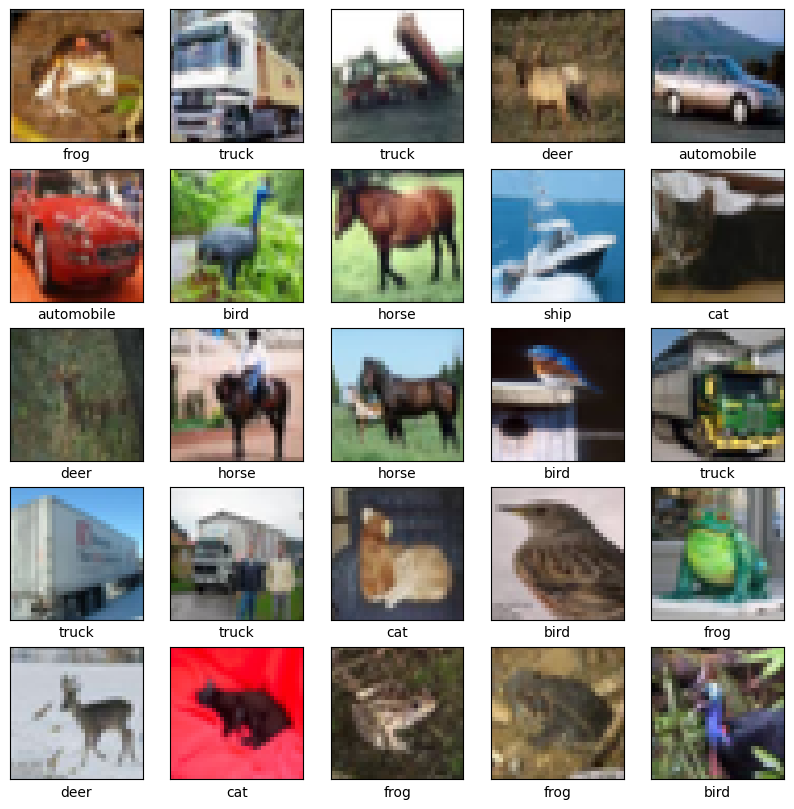

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# Checking the number of unique classes
print(np.unique(train_labels))
print(np.unique(test_labels))

# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255

# One hot encoding the target class (labels)
num_classes = 10
train_labels = utils.to_categorical(train_labels, num_classes)
test_labels = utils.to_categorical(test_labels, num_classes)

# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [7]:
%%time
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=64, epochs=100,
                    validation_data=(test_images, test_labels))

# Save neural network structure
model_structure = model.to_json()
f = open("model1_structure.json", "w")
f.write(model_structure)
# Save neural network's trained weights
model.save_weights("model1.weights.h5")

Epoch 1/100
782/782 [==============================] - 22s 15ms/step - loss: 1.7388 - accuracy: 0.4031 - val_loss: 1.3514 - val_accuracy: 0.5101
Epoch 2/100
782/782 [==============================] - 11s 14ms/step - loss: 1.1737 - accuracy: 0.5802 - val_loss: 0.9848 - val_accuracy: 0.6472
Epoch 3/100
782/782 [==============================] - 10s 13ms/step - loss: 0.9929 - accuracy: 0.6479 - val_loss: 0.8519 - val_accuracy: 0.6952
Epoch 4/100
782/782 [==============================] - 11s 13ms/step - loss: 0.8826 - accuracy: 0.6907 - val_loss: 0.8227 - val_accuracy: 0.7101
Epoch 5/100
782/782 [==============================] - 10s 13ms/step - loss: 0.8044 - accuracy: 0.7189 - val_loss: 0.7272 - val_accuracy: 0.7468
Epoch 6/100
782/782 [==============================] - 11s 14ms/step - loss: 0.7559 - accuracy: 0.7377 - val_loss: 0.7399 - val_accuracy: 0.7504
Epoch 7/100
782/782 [==============================] - 11s 14ms/step - loss: 0.7073 - accuracy: 0.7551 - val_loss: 0.5977 - val_ac

Text(0.5, 1.0, 'Loss Curves')

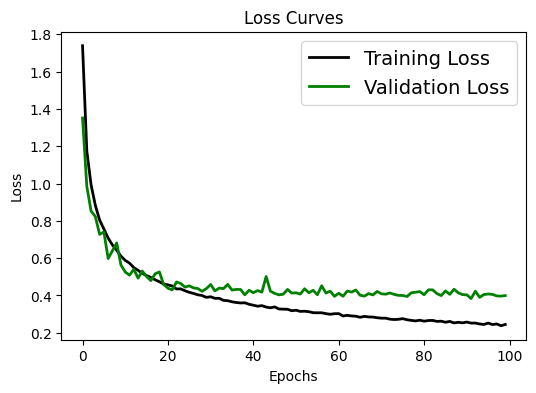

In [8]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

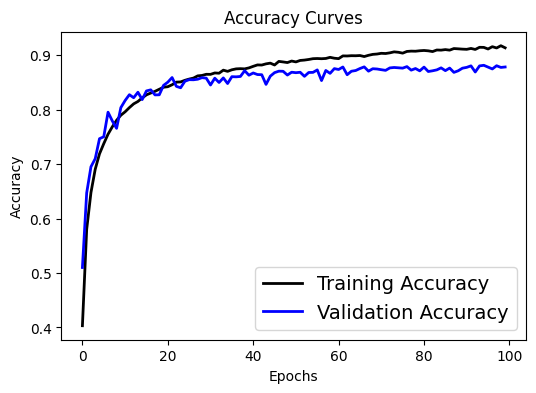

In [9]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

313/313 [==============================] - 2s 3ms/step
[[1.00685238e-05 3.23621606e-07 2.31759870e-04 ... 1.59056157e-07
  3.16999802e-07 1.01852393e-08]
 [1.01178797e-04 8.34380568e-04 5.27723465e-09 ... 4.50569894e-11
  9.99064386e-01 1.74068902e-07]
 [1.88556705e-02 7.18580723e-01 3.99825658e-05 ... 1.40845907e-04
  2.61280656e-01 8.23445152e-04]
 ...
 [1.81956020e-10 8.53978166e-10 1.14111135e-05 ... 3.35561617e-06
  2.13314544e-09 1.65202452e-09]
 [4.21320647e-03 9.93939400e-01 1.47702776e-05 ... 5.94913618e-05
  9.30815349e-06 1.43336511e-04]
 [5.21920784e-10 1.04970199e-09 1.24851338e-08 ... 9.99945998e-01
  2.90813096e-10 1.07392442e-10]]
[3 8 1 ... 5 1 7]


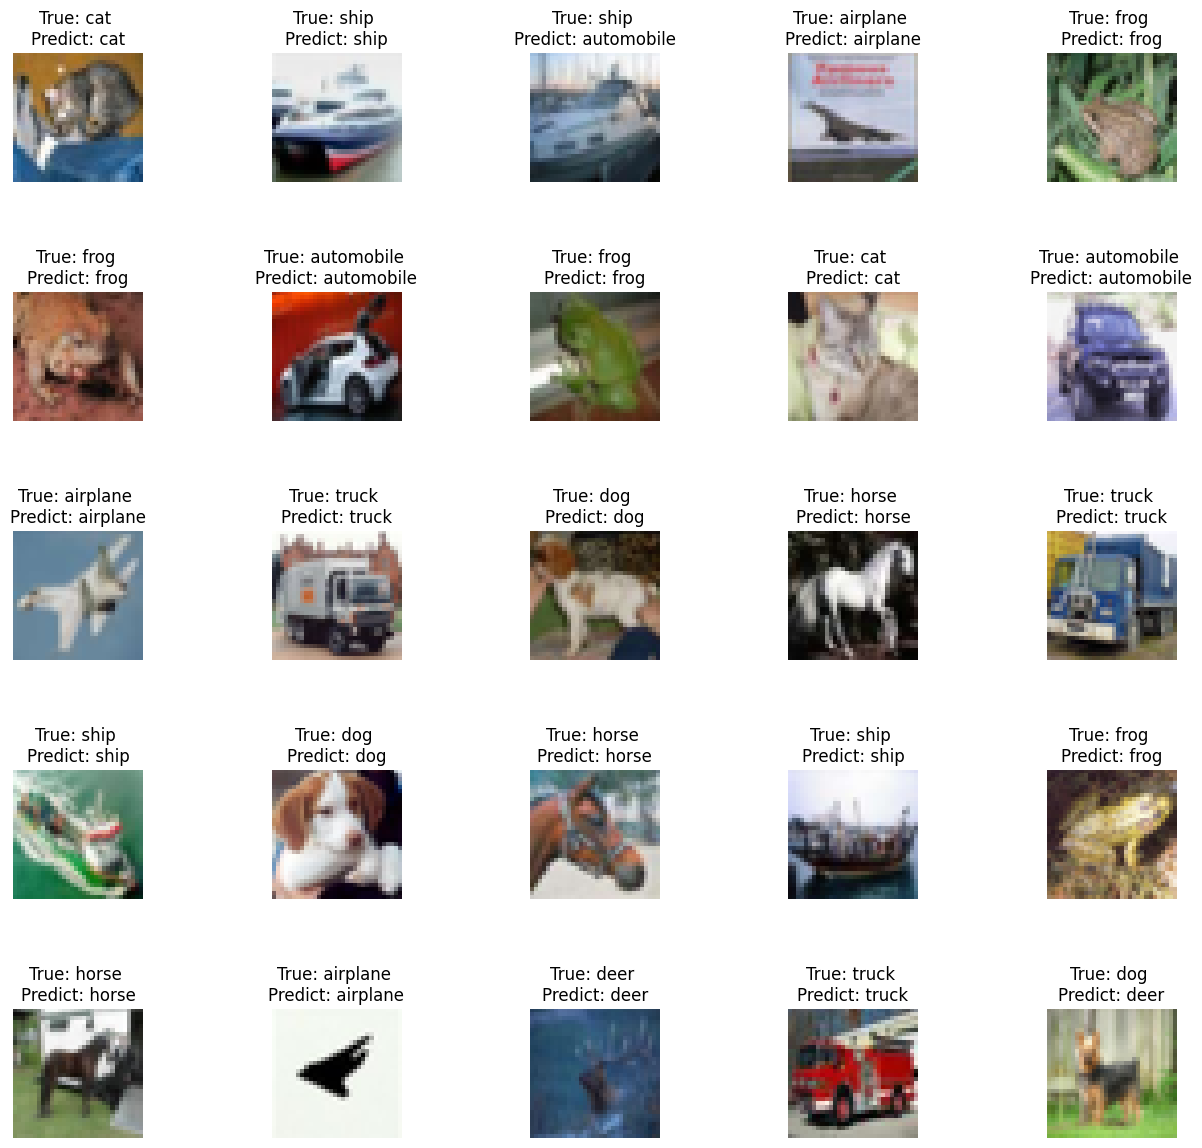

In [10]:
# Making the Predictions
pred = model.predict(test_images)
print(pred)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)